<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#정상-데이터를-구할-수-있는-경우" data-toc-modified-id="정상-데이터를-구할-수-있는-경우-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>정상 데이터를 구할 수 있는 경우</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [62]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, LayerNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv1DTranspose, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, RepeatVector
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
# MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import losses
# MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant

plt.style.use("dark_background")

In [81]:
cpu_load = pd.read_csv("Datasets/CPU/cpu_load.csv", parse_dates=["timestamp"], infer_datetime_format=True, index_col="timestamp")
cpu_load = cpu_load.asfreq("5T")

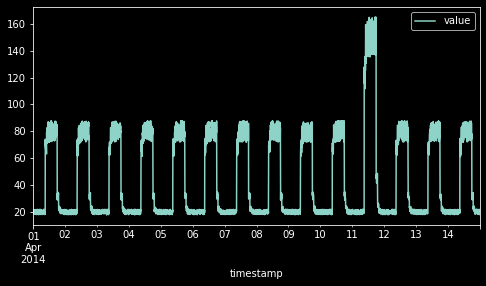

In [84]:
cpu_load.plot.line(figsize=(8, 4));

# 정상 데이터를 구할 수 있는 경우
- Known anomaly를 제거합니다.

In [85]:
cpu_load_normal = pd.read_csv("Datasets/CPU/cpu_load_normal.csv", parse_dates=["timestamp"], infer_datetime_format=True, index_col="timestamp")
cpu_load_normal = cpu_load_normal.asfreq("5T")

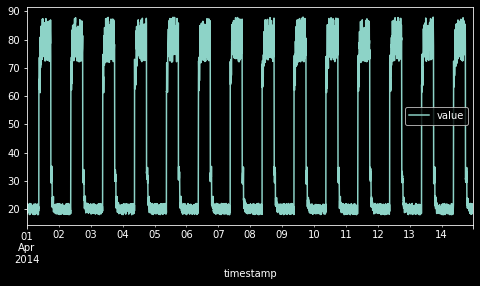

In [86]:
cpu_load_normal.plot.line(figsize=(8, 4));

In [89]:
mean_tr = cpu_load_normal.mean()
std_tr = cpu_load_normal.std()
cpu_load_sc = (cpu_load_normal - mean_tr)/std_tr

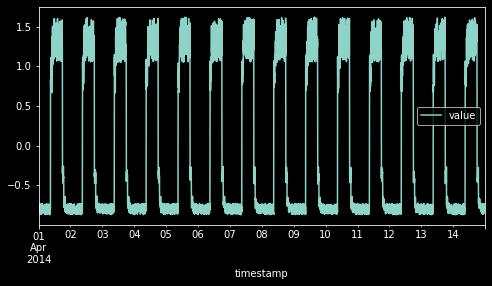

In [91]:
cpu_load_sc.plot.line(figsize=(8, 4));

In [158]:
window_size = 288
def blocked_cv(data, window_size=window_size, h=0):
    X = list()
    for i in range(len(data) - window_size - h + 1):
        X.append(data[i:i + window_size])
    return np.array(X)

X_train = blocked_cv(cpu_load_sc)

# Modeling

In [123]:
inputs = Input(shape=(288, 1))

# Encoder
z = Conv1D(filters=32, kernel_size=7, strides=2, padding="same", activation="relu")(inputs)
z = Dropout(rate=0.2)(z)
z = Conv1D(filters=16, kernel_size=7, strides=2, padding="same", activation="relu")(z)
z = Conv1D(filters=8, kernel_size=7, strides=2, padding="same", activation="relu")(z)
z = Conv1D(filters=4, kernel_size=7, strides=2, padding="same", activation="relu")(z)
        
# Decoder
z = Conv1DTranspose(filters=8, kernel_size=7, strides=2, padding="same", activation="relu")(z)
z = Conv1DTranspose(filters=16, kernel_size=7, strides=2, padding="same", activation="relu")(z)
z = Dropout(rate=0.2)(z)
z = Conv1DTranspose(filters=32, kernel_size=7, strides=2, padding="same", activation="relu")(z)
z = Conv1DTranspose(filters=32, kernel_size=7, strides=2, padding="same", activation="relu")(z)
outputs = Conv1DTranspose(filters=1, kernel_size=7, strides=1, padding="same")(z)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mse"])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 288, 1)]          0         
                                                                 
 conv1d_36 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_17 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_37 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_38 (Conv1D)          (None, 36, 8)             904       
                                                                 
 conv1d_39 (Conv1D)          (None, 18, 4)             228       
                                                                 
 conv1d_transpose_40 (Conv1D  (None, 36, 8)            232 

In [126]:
es = EarlyStopping(monitor="val_mse", mode="auto", verbose=1, patience=8)
model_path = "cpu_load_autoencoder.h5"
mc = ModelCheckpoint(filepath=model_path, monitor="val_mse", mode="auto", verbose=1, save_best_only=True)
hist = model.fit(x=X_train, y=X_train, validation_split=0.2, epochs=50, batch_size=128, shuffle=False, verbose=2, callbacks=[es, mc])

Epoch 1/50

Epoch 1: val_mse improved from inf to 0.02763, saving model to cpu_load_autoencoder.h5
24/24 - 4s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0276 - val_mse: 0.0276 - 4s/epoch - 157ms/step
Epoch 2/50

Epoch 2: val_mse improved from 0.02763 to 0.02533, saving model to cpu_load_autoencoder.h5
24/24 - 4s - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0253 - val_mse: 0.0253 - 4s/epoch - 150ms/step
Epoch 3/50

Epoch 3: val_mse improved from 0.02533 to 0.02453, saving model to cpu_load_autoencoder.h5
24/24 - 4s - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0245 - val_mse: 0.0245 - 4s/epoch - 163ms/step
Epoch 4/50

Epoch 4: val_mse did not improve from 0.02453
24/24 - 4s - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0249 - val_mse: 0.0249 - 4s/epoch - 148ms/step
Epoch 5/50

Epoch 5: val_mse did not improve from 0.02453
24/24 - 3s - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0259 - val_mse: 0.0259 - 3s/epoch - 141ms/step
Epoch 6/50

Epoch 6: val_mse improved from 0.02453 to 0.02442, saving mode

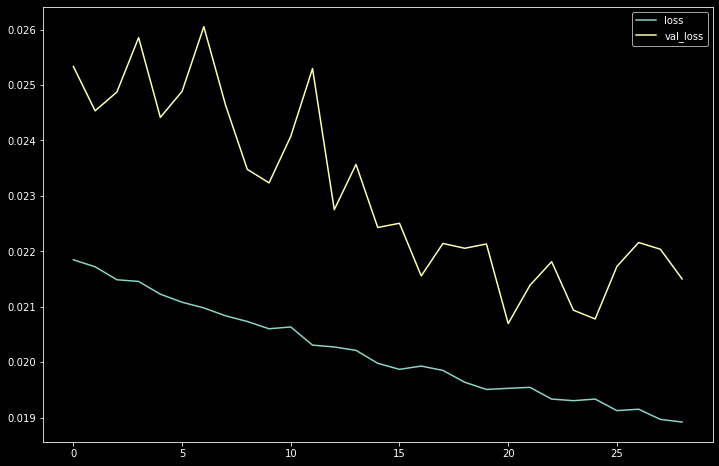

In [127]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
axes.plot(hist.history["loss"][1:], label="loss");
axes.plot(hist.history["val_loss"][1:], label="val_loss");
axes.legend();

118/118 [==============================] - 3s 21ms/step


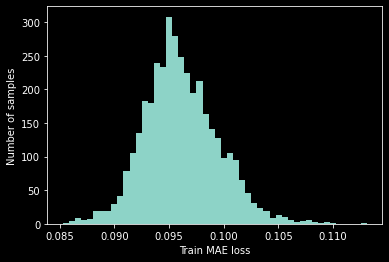

In [150]:
# 학습 데이터를 그대로 복원 -> 복원된 데이터와 학습 데이터를 비교
y_pred = model.predict(X_train)
mae = np.mean(np.abs(y_pred - X_train), axis=1)

plt.hist(mae, bins=50);
plt.xlabel("Train MAE loss");
plt.ylabel("Number of samples");

In [153]:
# Get reconstruction loss threshold.
# 학습 데이터의 최대 에러의 95% 수준보다 넘어가는건 이상치다.
thr = np.max(mae)*0.95
print(f"Reconstruction Error Threshold: {thr}")

Reconstruction Error Threshold: 0.10743919293251913


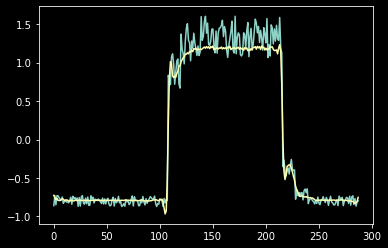

In [154]:
plt.plot(X_train[0]);
plt.plot(y_pred[0]);

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 3s 22ms/step


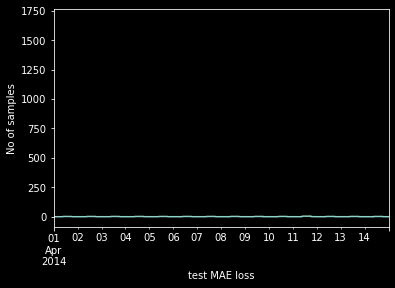

Number of anomaly samples:  484
Indices of anomaly samples:  (array([ 212,  213,  214,  218,  219,  779,  781,  782,  783,  784,  785,
        786,  787,  788,  789,  790,  791,  793,  794,  795,  796,  797,
        798,  799,  800,  801,  802, 1641, 1642, 1645, 1646, 1647, 1648,
       1649, 1650, 1651, 1652, 1653, 1654, 1655, 1657, 1658, 1659, 1660,
       1661, 1662, 1663, 1939, 1940, 1941, 1942, 1943, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 2506, 2507, 2510, 2511, 2515, 2516, 2517,
       2518, 2519, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529,
       2530, 2538, 2539, 2558, 2574, 2701, 2702, 2703, 2704, 2705, 2706,
       2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2

In [159]:
df_test_value = (cpu_load - mean_tr)/std_tr

df_test_value.plot.line(legend=False);

# Create sequences from test values.
x_test = blocked_cv(df_test_value.values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > thr # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [160]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomaly_idxs = list()
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomaly_idxs.append(data_idx)

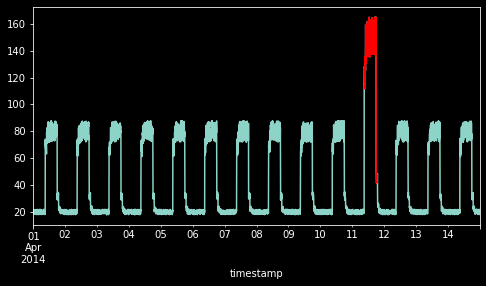

In [163]:
anomalies = cpu_load.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(8, 4))
cpu_load.plot(legend=False, ax=ax);
anomalies.plot(legend=False, ax=ax, color="r");